第12回の演習です。ニューラルネットワークを導入し、ファッションのデータセットを使ってアイテムの画像を認識します。
左上の「ファイル」＞「ドライブにコピーを保存」を選択して、Google DriveにNotebookを保存します。ご自身のGoogleドライブの"Colab Notebooks"フォルダで、保存したNotebookを右クリックし、「アプリで開く」＞「Google Colaboratory」を選択します。その上で、各コードを実行するには、以下のコマンドを実行してください。実行は「再生」ボタンを押します。

In [ ]:
print("Chapter 12")

Chapter 12


# Kerasによるニューラルネットワーク
この回からKerasライブラリを導入し、ニューラルネットワークから始め、畳み込みニューラルネットワークへと発展させます。Kerasはニューラルネットワーク用のライブラリで、ニューラルネットワークを短いコードで実装できるようになっています。ここでは、計算処理を行うライブラリとしてTensorFlowを使います。TensorFlowは深層学習の計算処理を行う枠組みで、Kerasを通して使うことができます。

## Fashion-MNIST
手書き文字認識のデータセットMNISTは、前回導入したサポートベクトルマシンで約98%の識別率で認識できることが示されました。完璧に認識できるようになったというわけではありませんが、それでも機械学習の旧来の手法で98%まで達成できています。そこで、認識対象のデータセットを別のものに変えます。

Fashion-MNISTはKerasライブラリの中にデータセットとして備えられています。ありがたいことに、モデルを作るための学習用データと、そのモデルを確認するための検証用データに分けられています。

In [ ]:
# Fashion-MNISTデータセット
from tensorflow.keras.datasets import fashion_mnist
(train_data, train_label), (test_data, test_label) = fashion_mnist.load_data()

# Fashion-MNISTのデータ形状
print(train_data.shape)         # 学習用データ
print(train_label.shape)        # 学習用データのラベル
print(test_data.shape)          # 検証用データ
print(test_label.shape)         # 検証用データのラベル

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


学習用データは6万点、検証用データは1万点あります。ここで、読み込んだデータを画像として表示してみます。

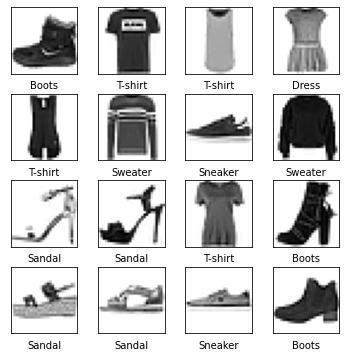

In [ ]:
# Fashion-MNISTの画像を表示
import matplotlib.pyplot as plt

# labelにアイテム名をつける
name_label = ["T-shirt", "Pants", "Sweater", "Dress", "Coat", "Sandal", "Blouse", "Sneaker", "Bag", "Boots"]

plt.figure(figsize = (6, 6))
# 学習用データから16個抽出して表示する
for i in range(16):
    # 4×4
    plt.subplot(4, 4, i + 1)
    # 縦方向の隙間
    plt.subplots_adjust(hspace = 0.3)
    # 軸の目盛りを表示しない
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[i], cmap = "binary")
    # 横軸にアイテム名を表示
    plt.xlabel(name_label[train_label[i]])

plt.show()

train_dataに格納されている画像データを出力すると、以下のように画素数28×28の画素で構成され、画素値は0-255の範囲をとっていることがわかります。

In [ ]:
print(train_data[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

## 前処理
データの前処理を行います。画像は全部で6万点あり、それぞれの画像は28×28画素で構成されます。本当は学習用データを全部使いたいのですが、特にCNNを構成したときに計算時間が膨大になってしまいます。そこで、一部を抽出してデータ数を少なくしておきます。次に、それぞれ0-255の範囲の画素値を、0-1.0に正規化します。このとき、Kerasからロードしたデータはndarray配列ですが、データの型は"uint8"（符号付8ビット整数）になっています。識別モデルに渡すにはこのデータ型を"float32"（32ビット浮動小数点数）に変換する必要があります。

In [ ]:
import numpy as np
# データ抽出
train_data0 = train_data[0:10000, : , : ]
train_label0 = train_label[0:10000]
valid_data0 = train_data[10000:11000, : , : ]
valid_label0 = train_label[10000:11000]

# データ型
print(train_data0.dtype, valid_data0.dtype)
print(train_data0.shape, valid_data0.shape)

# uint8 -> float32
train_data1 = train_data0.astype("float32") / 255
valid_data1 = valid_data0.astype("float32") / 255

# データ型
print(train_data1.dtype, valid_data1.dtype)
print(train_data1.shape, valid_data1.shape)

print("学習用データ")
print(train_data1.min(), "-", train_data1.max())
print(train_label0.min(), "-", train_label0.max())
print("検証用データ")
print(valid_data1.min(), "-", valid_data1.max())
print(valid_label0.min(), "-", valid_label0.max())

uint8 uint8
(10000, 28, 28) (1000, 28, 28)
float32 float32
(10000, 28, 28) (1000, 28, 28)
学習用データ
0.0 - 1.0
0 - 9
検証用データ
0.0 - 1.0
0 - 9


画像データに対するラベルを表示します。そうしますと、学習用データの最初のラベルは"9"と表示されたはずです。これは"Boots"を表します。"0"から"9まで"の10種類あります。このように正解ラベルが数字の配列として、学習用データに対して6万個、検証用データに対して1万個、格納されているのです。それぞれone-hotベクトルに変換します。

In [ ]:
# keras.utilsからto_categoricalをインポート
from tensorflow.keras.utils import to_categorical

# ラベルの表示
print("学習用", train_label0, len(train_label0))
print("検証用", valid_label0, len(valid_label0))

# one-hot vector
train_label1 = to_categorical(train_label0)
valid_label1 = to_categorical(valid_label0)

print("学習用", train_label1, len(train_label1))
print("検証用", valid_label1, len(valid_label1))

学習用 [9 0 0 ... 0 6 6] 10000
検証用 [8 7 6 8 7 7 2 0 5 3 5 5 1 3 9 4 1 9 3 2 8 2 9 3 4 5 1 0 3 2 8 5 3 8 2 2 9
 7 7 9 9 1 2 6 7 6 6 6 6 7 3 7 8 5 9 5 9 1 5 9 8 3 6 1 1 0 3 3 1 2 9 8 9 5
 1 0 6 2 3 0 0 8 8 5 7 3 6 9 7 3 6 4 8 5 0 8 3 6 7 1 5 1 7 6 4 1 6 9 8 1 1
 7 7 0 7 4 9 4 2 9 9 9 6 5 2 3 5 6 5 1 9 6 1 5 6 9 3 5 3 5 3 2 7 0 9 1 1 2
 1 3 6 4 8 4 1 3 2 6 2 0 9 5 8 6 5 5 6 8 0 8 3 9 6 9 8 3 2 5 8 3 9 0 9 9 8
 1 3 8 4 9 9 0 3 0 0 6 7 8 6 6 4 6 3 9 0 4 6 7 2 5 6 2 9 7 0 2 2 3 8 4 7 6
 8 7 3 6 2 1 3 7 0 4 7 7 5 9 4 9 4 7 1 5 4 6 2 7 1 6 1 4 5 5 8 2 9 9 9 4 7
 7 5 2 0 9 1 5 0 4 9 6 8 8 3 3 6 2 6 4 5 8 0 5 2 3 4 9 2 8 5 7 4 4 0 5 3 5
 3 5 3 0 0 4 5 0 1 7 6 7 9 0 8 1 4 9 0 6 9 8 8 9 2 9 3 4 2 2 5 9 9 4 1 9 4
 4 5 1 9 2 6 1 2 5 7 3 9 9 2 2 7 1 5 0 9 6 6 4 5 4 4 1 1 6 8 0 7 9 2 3 0 8
 7 3 2 2 5 3 5 5 0 8 1 4 5 1 8 6 1 1 0 1 5 1 9 5 9 1 0 4 9 5 9 2 6 3 7 7 3
 7 2 8 1 5 0 2 8 3 6 6 1 0 8 1 3 5 5 1 4 8 9 3 0 3 3 5 6 4 6 1 3 0 0 7 5 2
 9 2 8 0 4 2 2 0 7 9 7 7 6 4 0 3 3 6 2 0 4 5 8 1 3 5 9 6 6 0 6 5 8 8

## ニューラルネットワークの構成
画像は28×28画素で構成されますから、ニューラルネットワークの入力層は画像1枚のデータの配列784個分のユニットを持つとします。つまり、1つの画素値を1つのユニットに渡す感じになります。中間層のユニット数は256に設定します。出力層は正解ラベルの種類の配列10個分のユニットを持つとします。重みを更新する調整量（学習係数）を0.1とし、学習を繰り返す回数（エポック数）を20とします（取りあえず）。
- 入力層のユニット数：28×28 = 784
- 中間層のユニット数：256
- 出力層のユニット数：10
- 学習係数：0.1
- 学習を繰り返す回数：20
- ミニバッチのサイズ：64

In [ ]:
# Neural Network
img_row = 28                # 入力層のユニット数
img_col = 28
unit_middle = 256           # 中間層のユニット数
unit_output = 10            # 出力層のユニット数
learning_rate = 0.1         # 学習係数
epochs = 20                 # 学習を繰り返す回数（エポック数）
batch_size = 64             # ミニバッチのサイズ

tensorflow.kerasモジュールで、ニューラルネットワークを構成します。Sequential()でSequentialクラスのオブジェクトを生成（モデルを定義）し、model.add()で層を追加していきます。Flattenは、入力データを1次元配列に変換します。

In [ ]:
# ニューラルネットワークの構築
# keras.modelsからSequentialをインポート
from tensorflow.keras.models import Sequential
# keras.layersからDenseとFlattenをインポート
from tensorflow.keras.layers import Dense, Flatten
# keras.optimizersからSGDをインポート
from tensorflow.keras.optimizers import SGD

model = Sequential()

# 入力層
model.add(Flatten(input_shape = (img_row, img_col)))

# 中間層
model.add(Dense(unit_middle, activation = "sigmoid"))

# 出力層
model.add(Dense(unit_output, activation = "softmax"))

# モデルの概要を出力
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


## モデルのコンパイル
compile()メソッドでSequentialオブジェクトをコンパイルします。このとき、最適化手法、損失関数（評価関数）、学習評価の指標を指定します。
- 最適化手法
 - SGD
 - rmsprop
- 損失関数
 - binary_crossentropy：二値分類
 - categorical_crossentropy：他クラス単一ラベル分類
- 学習評価の指標
 - accuracy：正確度


In [ ]:
# モデルのコンパイル
model.compile(
    optimizer = SGD(learning_rate),            # SGD
    loss = "categorical_crossentropy",         # 交差エントロピー誤差
    metrics = ["accuracy"]                     # 学習評価の指標はaccuracy
)

## 学習の実行
fit()メソッドで学習を実行します。引数verboseは学習の進捗を表示するかどうかを指定します（"verbose = 1"で、学習の進捗を表示）。

In [ ]:
# 学習を実行し、結果を出力する
print(train_data1.shape, train_label1.shape)
print(valid_data1.shape, valid_label1.shape)
history = model.fit(train_data1,
                    train_label1,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1,
                    validation_data = (valid_data1, valid_label1)
)

(10000, 28, 28) (10000, 10)
(1000, 28, 28) (1000, 10)
Epoch 1/20
157/157 [==============================] - 7s 7ms/step - loss: 1.3035 - accuracy: 0.5979 - val_loss: 0.9028 - val_accuracy: 0.7140
Epoch 2/20
157/157 [==============================] - 1s 5ms/step - loss: 0.7856 - accuracy: 0.7370 - val_loss: 0.7096 - val_accuracy: 0.7540
Epoch 3/20
157/157 [==============================] - 1s 5ms/step - loss: 0.6774 - accuracy: 0.7593 - val_loss: 0.6630 - val_accuracy: 0.7620
Epoch 4/20
157/157 [==============================] - 1s 6ms/step - loss: 0.6174 - accuracy: 0.7842 - val_loss: 0.5675 - val_accuracy: 0.8120
Epoch 5/20
157/157 [==============================] - 1s 4ms/step - loss: 0.5812 - accuracy: 0.7949 - val_loss: 0.5498 - val_accuracy: 0.8190
Epoch 6/20
157/157 [==============================] - 1s 3ms/step - loss: 0.5516 - accuracy: 0.8062 - val_loss: 0.5320 - val_accuracy: 0.8090
Epoch 7/20
157/157 [==============================] - 1s 3ms/step - loss: 0.5309 - accuracy: 0

損失関数の値、正確度を図示します。これらの値は、ニューラルネットワークのモデルを学習する過程で取得され、変数historyに代入されています。


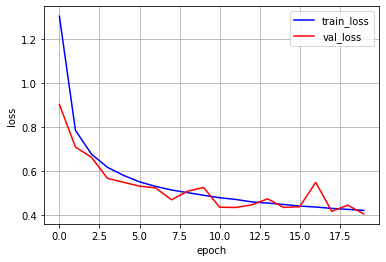

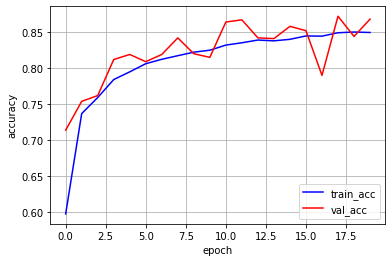

In [ ]:
# Loss & Accuracy
import matplotlib.pyplot as plt

# 学習用データの損失
plt.plot(history.history["loss"],
         color = "blue",
         label = "train_loss")
# 検証用データの損失
plt.plot(history.history["val_loss"],
         color = "red",
         label = "val_loss")
plt.legend(loc = "upper right")       # 凡例
plt.grid()                            # グリッド
plt.xlabel("epoch")                   # x軸
plt.ylabel("loss")                    # y軸
plt.show()

# 学習用データの正確度
plt.plot(history.history["accuracy"],
         color = "blue",
         label = "train_acc")
# 検証用データの損失
plt.plot(history.history["val_accuracy"],
         color = "red",
         label = "val_acc")
plt.legend(loc = "lower right")       # 凡例
plt.grid()                            # グリッド
plt.xlabel("epoch")                   # x軸
plt.ylabel("accuracy")                # y軸
plt.show()

## 評価
ニューラルネットワークのモデルを評価します。モデルの学習に使っていない検証用データを使います。evaluate()は評価を行うメソッドで、学習済みのモデルにデータを入力し、順伝播の計算を実施して分類の推定値を返します。

In [ ]:
# データ抽出
test_data0 = test_data[0:2000, : , : ]
test_label0 = test_label[0:2000]

# データ型
print(test_data0.dtype)
print(test_data0.shape)

# uint8 -> float32
test_data1 = test_data0.astype("float32") / 255

# データ型
print(test_data1.dtype)
print(test_data1.shape)

print("評価用データ")
print(test_data1.min(), "-", test_data1.max())
print(test_label0.min(), "-", test_label0.max())


# ラベルの表示
print("検証用", test_label0, len(test_label0))

# one-hot vector
test_label1 = to_categorical(test_label0)
print("検証用", test_label1, len(test_label1))


# 検証
score = model.evaluate(test_data1, test_label1, verbose = 1)
# 検証用データの誤り率
print("Test Loss : ", score[0])
# 検証用データの正確度
print("Test Accuracy : ", score[1])

uint8
(2000, 28, 28)
float32
(2000, 28, 28)
評価用データ
0.0 - 1.0
0 - 9
検証用 [9 2 1 ... 3 6 0] 2000
検証用 [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]] 2000
63/63 [==============================] - 0s 2ms/step - loss: 0.4646 - accuracy: 0.8415
Test Loss :  0.4645967483520508
Test Accuracy :  0.8414999842643738
